In [1]:
import numpy as np
import seaborn as sb
import pandas
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import torch
import time
from torchviz import make_dot

# Part1.1
Define create_model function with 2 layers and 3 layers\
We separate 2 cases for 2 layers and 3 layers\

* if 2 layers
    * first layer dimension : (input_dim, hidden_nodes)
    * second layer dimension : (hidden_nodes, outpus_dim)
* if 3 layers
    * first layer dimension : (input_dim, hidden_nodes)
    * second layer dimension : (hidden_nodes, hidden_nodes)
    * third layer dimension : (hidden_nodes, outpus_dim)


In [2]:
def relu(X):
    return np.maximum(X, 0)

def relu_derivative(X):
    return 1. * (X>0)

def tanh(X):
    return np.tanh(X)

def tanh_derivative(X):
    return (1. -tanh(X)**2)

def logistic(X):
    return (1.0/(1.0 + np.exp(-X)))

def logistic_derivative(X):
    return (logistic(X) * (1.0-logistic(X)))

def actv_func(X):
    return 

In [71]:
# create a two-layer neural network
def create_model(X, hidden_nodes,output_dim=2, activation_function = "relu", hidden_layers_num = 2):
    # this will hold a dictionary of layers
    model = {}
    # input dimensionality
    input_dim = X.shape[1]

    # First set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes) / np.sqrt(input_dim)
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes))
    
    if hidden_layers_num == 3:
        # Second set of weights from hidden layer 1 to output
        model['W2'] = np.random.randn(hidden_nodes, hidden_nodes) / np.sqrt(hidden_nodes)
        # set of biases
        model['b2'] = np.zeros((1, hidden_nodes))
        # Third set of weights from hidden layer 2 to output
        model['W3'] = np.random.randn(hidden_nodes, output_dim) / np.sqrt(hidden_nodes)
        # set of biases
        model['b3'] = np.zeros((1, output_dim))

    elif hidden_layers_num == 2:
        # Second set of weights from hidden layer 1 to output
        model['W2'] = np.random.randn(hidden_nodes, output_dim) / np.sqrt(hidden_nodes)
        # set of biases
        model['b2'] = np.zeros((1, output_dim))
    else:
        raise NotImplementedError

    return model

# defines the forward pass given a model and data
def forward(model, x, activation_function = "relu", hidden_layers_num = 2):
    # get weights and biases
    if hidden_layers_num == 3:
        W1, b1, W2, b2, W3, b3= model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    elif hidden_layers_num == 2:
        W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    else:
        raise NotImplementedError

    # first layer
    z1 = x.dot(W1) + b1
    
    # First activation function
    if activation_function == "relu":
        a1 = relu(z1)
    elif activation_function == "logistic":
        a1 = logistic(z1)
    elif activation_function == "tanh":
        a1 = tanh(z1)
    else:
        raise NotImplementedError
    
    # second layer
    z2 = a1.dot(W2) + b2
    
    out = z2

    if hidden_layers_num == 3:
        # Second activation function
        if activation_function == "relu":
            a2 = relu(z2)
        elif activation_function == "logistic":
            a2 = logistic(z2)
        elif activation_function == "tanh":
            a2 = tanh(z2)
        else:
            raise NotImplementedError

        # third layer
        z3 = a2.dot(W3) + b3

        # no activation function as this is simply a linear layer!!
        out = z3
        return [a1, a2], out
    return [a1], out

# define the regression loss
def calculate_loss(model,X,y,reg_lambda, activation_function, hidden_layers_num = 2):
    num_examples = X.shape[0]

    # get weights and biases
    if hidden_layers_num == 3:
        W1, b1, W2, b2, W3, b3= model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    elif hidden_layers_num == 2:
        W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    else:
        raise NotImplementedError

    # what are the current predictions
    # outputs = (activation value, output)

    _, output = forward(model, X, activation_function, hidden_layers_num)
    
    # calculate L2 loss
    loss = 0.5 * np.sum((output-y) **2)
    
    # add regulatization term to loss
    loss += reg_lambda/2 * ( np.sum(np.square(W1)) + np.sum(np.square(W2)) )
    
    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop(X,y,a_value,model,output,reg_lambda, activation_function = "relu", hidden_layers_num = 2):
    # 3 hidden layers
    if hidden_layers_num == 3:
        # derivative of loss function
        delta4 = (output - y) / X.shape[0]

        # multiply this by activation outputs of hidden layer
        dW3 = (a_value[1].T).dot(delta4)
        #5and over all neurons
        db3 = np.sum(delta4, axis = 0, keepdims = True)

        # derivative of activation function
        if activation_function == "relu":
            delta3 = delta4.dot(model["W3"].T) * relu_derivative(a_value[1])
        elif activation_function == "logistic":
            delta3 = delta4.dot(model["W3"].T) * logistic_derivative(a_value[1])
        elif activation_function == "tanh":
            delta3 = delta4.dot(model["W3"].T) * tanh_derivative(a_value[1])
        else:
            delta3 = None
    # 2 hidden layers
    elif hidden_layers_num == 2:
        delta3 = (output - y) / X.shape[0]
    else:
        raise NotImplementedError


    # multiply this by activation outputs of hidden layer
    dW2 = (a_value[0].T).dot(delta3)
    # and over all neurons
    db2 = np.sum(delta3, axis = 0, keepdims = True)

    # derivative of activation function
    if activation_function == "relu":
        delta2 = delta3.dot(model["W2"].T) * relu_derivative(a_value[0])
    elif activation_function == "logistic":
        delta2 = delta3.dot(model["W2"].T) * logistic_derivative(a_value[0])
    elif activation_function == "tanh":
        delta2 = delta3.dot(model["W2"].T) * tanh_derivative(a_value[0])
    else:
        delta2 = None
    # multiply by input data
    dW1 = (X.T).dot(delta2)
    # and sum over all neurons
    db1 = np.sum(delta2, axis = 0)
    
    # add regularization terms on the two weights
    dW2 += reg_lambda * model["W2"]
    dW1 += reg_lambda * model["W1"]
    if hidden_layers_num == 3:
        dW3 += reg_lambda * model["W3"]
        return dW1, dW2, dW3, db1, db2, db3
    
    return dW1, dW2, db1, db2

# simple training loop
def train(model, X, y, num_passes=100000, reg_lambda = 0.1, learning_rate = 0.001, sgd = True, activation_function = "relu", hidden_layers_num = 2):
    # whether to do stochastic gradient descent
    sgd = False
    
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while done == False:
        # SGD or not
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False)
            input_data = X[randinds,:]
            target = y[randinds]
        else:
            input_data = X
            target = y

        # 2 cases of hidden layers number 
        if hidden_layers_num == 3:
            # get predictions
            # a_values : (a1, a2)
            a_values, output = forward(model, input_data, activation_function, hidden_layers_num)
            # feed this into backprop
            dW1, dW2, dW3, db1, db2, db3 = backprop(input_data,target,a_values,model,output,reg_lambda, activation_function, hidden_layers_num)

            # given the results of backprop, update both weights and biases
            model['W1'] -= learning_rate * dW1
            model['b1'] -= learning_rate * db1
            model['W2'] -= learning_rate * dW2
            model['b2'] -= learning_rate * db2
            model['W3'] -= learning_rate * dW3
            model['b3'] -= learning_rate * db3

        elif hidden_layers_num == 2:
            # get predictions
            # a_values : (a1)
            a_values, output = forward(model, input_data, activation_function, hidden_layers_num)
            # feed this into backprop
            dW1, dW2, db1, db2 = backprop(input_data,target,a_values,model,output,reg_lambda, activation_function, hidden_layers_num)
            
            # given the results of backprop, update both weights and biases
            model['W1'] -= learning_rate * dW1
            model['b1'] -= learning_rate * db1
            model['W2'] -= learning_rate * dW2
            model['b2'] -= learning_rate * db2
        else:
            raise NotImplementedError
            
        # do some book-keeping every once in a while
        if i % 1000 == 0:
            loss = calculate_loss(model, X, y, reg_lambda, activation_function, hidden_layers_num)
            losses.append(loss)
            print("Loss after iteration {}: {}".format(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-loss)/previous_loss) < 0.001:
                done = True
            previous_loss = loss
        i += 1
        if i>=num_passes:
            done = True
    return model, losses

### create data for regression

In [84]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1

## Training
### 1. 8 neurons for the two-layer version

In [85]:
# training set size
num_examples = len(X) 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 
# activation function type
activation_function = 'relu'
# Number of hidden layers
hidden_layers_num = 2
# Number of hidden layer nodes
hidden_nodes_num = 8
# Number of iteration
epochs = 100000
# Regularization?
regularization = False
# create the model
model = create_model(X,hidden_nodes_num,nn_output_dim, activation_function, hidden_layers_num = hidden_layers_num)

# train it
model, losses = train(model,X, y, num_passes = epochs, reg_lambda=reg_lambda, learning_rate=learning_rate, hidden_layers_num=hidden_layers_num, regularization= regularization)

# determine predictions of the trained model
_, output = forward(model, X, activation_function)

Loss after iteration 0: 1567.2923138423916
Loss after iteration 1000: 24.755141105011923
Loss after iteration 2000: 9.80743043223588
Loss after iteration 3000: 7.289883282089876


/home/jihoone/anaconda3/envs/mm/lib/python3.7/site-packages/ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in double_scalars


Loss after iteration 4000: 6.235016274632897
Loss after iteration 5000: 5.591930852715288
Loss after iteration 6000: 4.671639232368701
Loss after iteration 7000: 4.356076043583267
Loss after iteration 8000: 4.188369435513265
Loss after iteration 9000: 4.085624785751838
Loss after iteration 10000: 4.013722931086473
Loss after iteration 11000: 3.932310821298664
Loss after iteration 12000: 3.8719827656949617
Loss after iteration 13000: 3.8316596035829718
Loss after iteration 14000: 3.7969647794884986
Loss after iteration 15000: 3.771962924758828
Loss after iteration 16000: 3.7448284064812944
Loss after iteration 17000: 3.7248064030376997
Loss after iteration 18000: 3.7095045434026406
Loss after iteration 19000: 3.69311627907828
Loss after iteration 20000: 3.681318584946087
Loss after iteration 21000: 3.672117393049897
Loss after iteration 22000: 3.6549720498327245
Loss after iteration 23000: 3.5008897045288125
Loss after iteration 24000: 3.429790315343206
Loss after iteration 25000: 3.384

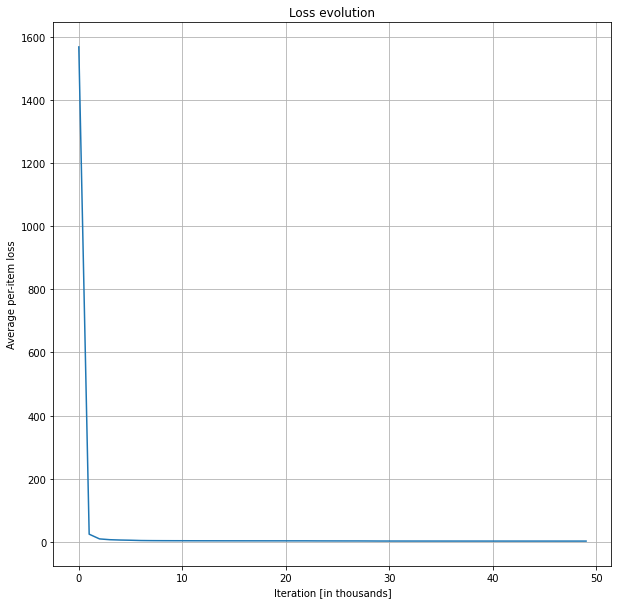

In [86]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

### 1-discussion
this version converges at 49000 iteration for loss 2.89

## 2. 4 + 4 neurons for the three-layer version

In [89]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1
        
# training set size
num_examples = len(X) 
# output layer dimensionality        a_list.append(a_out)
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 
# activation function type
activation_function = 'relu'
# Number of hidden layers
hidden_layers_num = 3
# Number of hidden layer nodes
hidden_nodes_num = 4
# Number of iteration
epochs = 100000
# Regularization?
regularization = False
# create the model
model = create_model(X,hidden_nodes_num,nn_output_dim, activation_function, hidden_layers_num = hidden_layers_num)

# train it
model, losses = train(model,X, y, num_passes = epochs, reg_lambda=reg_lambda, learning_rate=learning_rate, hidden_layers_num=hidden_layers_num, regularization= regularization)

# determine predictions of the trained model
_, output = forward(model, X, activation_function)

Loss after iteration 0: 1660.5101400934889
Loss after iteration 1000: 27.792085093981612
Loss after iteration 2000: 29.086330518162992


/home/jihoone/anaconda3/envs/mm/lib/python3.7/site-packages/ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in double_scalars


Loss after iteration 3000: 23.836862640359477
Loss after iteration 4000: 23.5989093520602
Loss after iteration 5000: 22.473600970783014
Loss after iteration 6000: 20.387700040432552
Loss after iteration 7000: 18.136310078963152
Loss after iteration 8000: 20.19860346007468
Loss after iteration 9000: 16.965683718519287
Loss after iteration 10000: 12.896293973946658
Loss after iteration 11000: 11.05252524009664
Loss after iteration 12000: 12.300892754895354
Loss after iteration 13000: 11.036031087749187
Loss after iteration 14000: 10.511174537966664
Loss after iteration 15000: 10.452261305138064
Loss after iteration 16000: 9.469356275963598
Loss after iteration 17000: 9.766887260756532
Loss after iteration 18000: 9.657665193070063
Loss after iteration 19000: 9.83706527291224
Loss after iteration 20000: 8.007159023783782
Loss after iteration 21000: 9.489554324706239
Loss after iteration 22000: 8.802986518702072
Loss after iteration 23000: 8.653018426445323
Loss after iteration 24000: 8.493

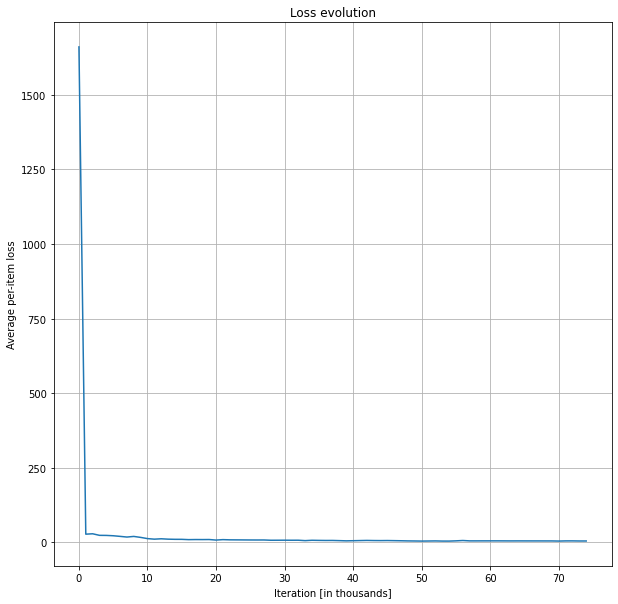

In [90]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

### 2-discussion
this version converges at 74000 iteration for loss 4.94

## 3. 16 neurons for the two-layer version

In [91]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1
        
# training set size
num_examples = len(X) 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 
# activation function type
activation_function = 'relu'
# Number of hidden layers
hidden_layers_num = 2
# Number of hidden layer nodes
hidden_nodes_num = 16
# Number of iteration
epochs = 100000
# Regularization?
regularization = False
# create the model
model = create_model(X,hidden_nodes_num,nn_output_dim, activation_function, hidden_layers_num = hidden_layers_num)

# train it
model, losses = train(model,X, y, num_passes = epochs, reg_lambda=reg_lambda, learning_rate=learning_rate, hidden_layers_num=hidden_layers_num, regularization= regularization)

# determine predictions of the trained model
_, output = forward(model, X, activation_function)

Loss after iteration 0: 1322.467591186342
Loss after iteration 1000: 28.01472711132636
Loss after iteration 2000: 10.923960986952187


/home/jihoone/anaconda3/envs/mm/lib/python3.7/site-packages/ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in double_scalars


Loss after iteration 3000: 7.318685446260795
Loss after iteration 4000: 5.741787104924324
Loss after iteration 5000: 4.352977879475026
Loss after iteration 6000: 3.4876591376553603
Loss after iteration 7000: 3.0204615388336626
Loss after iteration 8000: 2.7326647302770253
Loss after iteration 9000: 2.5224064273297713
Loss after iteration 10000: 2.301432100591819
Loss after iteration 11000: 2.1371991314050143
Loss after iteration 12000: 2.0076118594162846
Loss after iteration 13000: 1.9096381431024503
Loss after iteration 14000: 1.8312702805127352
Loss after iteration 15000: 1.7664141765558399
Loss after iteration 16000: 1.7154888979335234
Loss after iteration 17000: 1.6732808273128545
Loss after iteration 18000: 1.6326326865867051
Loss after iteration 19000: 1.6015500467791726
Loss after iteration 20000: 1.5770275386985244
Loss after iteration 21000: 1.5569283097143742
Loss after iteration 22000: 1.5394629002618354
Loss after iteration 23000: 1.511672510641105
Loss after iteration 2400

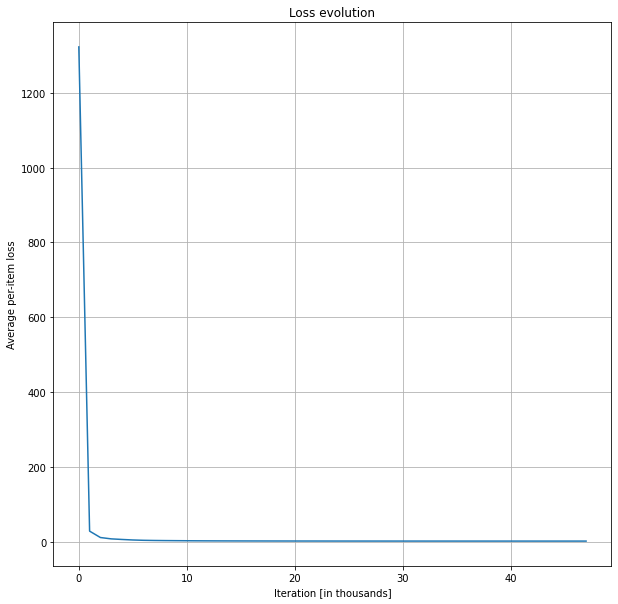

In [92]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

### 3-discussion
this version converges at 47000 iteration for loss 1.38

## 4. (8 + 8) neurons for the three-layer version

In [93]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1
        
# training set size
num_examples = len(X) 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 
# activation function type
activation_function = 'relu'
# Number of hidden layers
hidden_layers_num = 3
# Number of hidden layer nodes
hidden_nodes_num = 8
# Number of iteration
epochs = 100000
# Regularization?
regularization = False
# create the model
model = create_model(X,hidden_nodes_num,nn_output_dim, activation_function, hidden_layers_num = hidden_layers_num)

# train it
model, losses = train(model,X, y, num_passes = epochs, reg_lambda=reg_lambda, learning_rate=learning_rate, hidden_layers_num=hidden_layers_num, regularization= regularization)

# determine predictions of the trained model
_, output = forward(model, X, activation_function)

Loss after iteration 0: 1570.22156822473
Loss after iteration 1000: 12.257449805210404


/home/jihoone/anaconda3/envs/mm/lib/python3.7/site-packages/ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in double_scalars


Loss after iteration 2000: 7.826738511070668
Loss after iteration 3000: 6.708342668711517
Loss after iteration 4000: 4.604978875063478
Loss after iteration 5000: 3.6093632913695304
Loss after iteration 6000: 2.3404675812655746
Loss after iteration 7000: 2.040876975132822
Loss after iteration 8000: 2.2004102827645893
Loss after iteration 9000: 1.70425734890315
Loss after iteration 10000: 2.1600411878913737
Loss after iteration 11000: 1.7988282234033806
Loss after iteration 12000: 1.505980337755657
Loss after iteration 13000: 1.9021693547346743
Loss after iteration 14000: 1.4980720526272993
Loss after iteration 15000: 1.4830807951681948
Loss after iteration 16000: 1.3932427179779783
Loss after iteration 17000: 1.4288287240209174
Loss after iteration 18000: 1.2429993913060853
Loss after iteration 19000: 1.1953944090135358
Loss after iteration 20000: 1.070009598252699
Loss after iteration 21000: 1.045602214234909
Loss after iteration 22000: 1.1094226573208004
Loss after iteration 23000: 0.

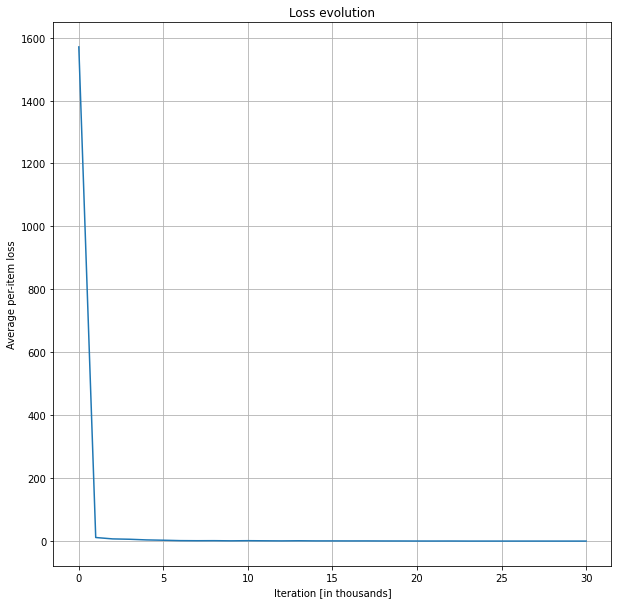

In [94]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

### 4-discussion
this version converges at 30000 iteration for loss 0.87

the model that has 8 neurons for each three hidden layers is the best model

# Bonus

In [5]:
# create a two-layer neural network
def create_model(X,hidden_nodes,output_dim, activation_function, hidden_layers_num):
    # this will hold a dictionary of layers
    model = {}
    # input dimensionality
    input_dim = X.shape[1]

    # First set of weights from input to hidden layer 1
    model['W1'] = np.random.randn(input_dim, hidden_nodes) / np.sqrt(input_dim)
    # set of biases
    model['b1'] = np.zeros((1, hidden_nodes))
    
    # 'n-2' number of Hidden layer that shapes (hidden_nodes, hidden_nodes)
    layer_num = 1
    for layer_num in range(2, hidden_layers_num):
        # set of n th weights
        model[f'W{layer_num}'] = np.random.randn(hidden_nodes, hidden_nodes) / np.sqrt(hidden_nodes)
        # set of biases
        model[f'b{layer_num}'] = np.zeros((1, hidden_nodes))

    # last set of weights from n th hidden layer to output
    model[f'W{layer_num+1}'] = np.random.randn(hidden_nodes, output_dim) / np.sqrt(hidden_nodes)
    # set of biases
    model[f'b{layer_num+1}'] = np.zeros((1, output_dim))

    return model
# defines the forward pass given a model and data
def forward(model, x, activation_function, hidden_layers_num):
    # get weights and biases
    weights = list(model.keys())
    a_list = []
    # first layer
    z1 = x.dot(model['W1']) + model['b1']

    z = z1
    for layer_num in range(2, hidden_layers_num*2, 2):
        # First activation function
        if activation_function == "relu":
            a_out = relu(z)
        elif activation_function == "logistic":
            a_out = logistic(z)
        elif activation_function == "tanh":
            a_out = tanh(z)
        else:
            raise NotImplementedError
        # Store activation valuese for backwards
        a_list.append(a_out)
        z = a_out.dot(model[weights[layer_num]]) + model[weights[layer_num+1]]

        # no activation function as this is simply a linear layer!!
    out = z
    return a_list, out

# define the regression loss
def calculate_loss(model,X,y,reg_lambda, activation_function, hidden_layers_num = 2, regularization = False):
    num_examples = X.shape[0]
    weights = list(model.keys())

    # what are the current predictions
    # outputs = (activation value, output)

    _, output = forward(model, X, activation_function, hidden_layers_num)
    
    # calculate L2 loss
    loss = 0.5 * np.sum((output-y) **2)
    
    if regularization:
        weight_sum = 0
        # add regulatization term to loss
        for n in range(0,len(weights),2):
            weight_sum += np.sum(np.square(model[weights[n]]))
        loss += reg_lambda/2 * weight_sum
    
    # return per-item loss
    return 1./num_examples * loss

# back-propagation for the two-layer network
def backprop(X,y,a_values,model,output,reg_lambda, activation_function = "relu", hidden_layers_num = 2):
    # last hidden layer
    delta_n = (output - y) / X.shape[0]
    # Store dW and db
    dW_dict = {}
    db_dict = {}
    delta = delta_n
    for num, actv in reversed(list(enumerate(a_values))):
        dW = (actv.T).dot(delta)
        dW_dict[f"dW{num+2}"] =dW
        # and over all neurons
        db = np.sum(delta, axis = 0, keepdims = True)
        db_dict[f"db{num+2}"] =db
        # derivative of activation function
        if activation_function == "relu":
            delta = delta.dot(model[f"W{num+2}"].T) * relu_derivative(actv)
        elif activation_function == "logistic":
            delta = delta.dot(model[f"W{num+2}"].T) * logistic_derivative(actv)
        elif activation_function == "tanh":
            delta = delta.dot(model[f"W{num+2}"].T) * tanh_derivative(actv)
        else:
            delta = None

    dW1 = (X.T).dot(delta)
    dW_dict["dW1"] = dW1
    # and sum over all neurons
    db1 = np.sum(delta, axis = 0)
    db_dict["db1"]= db1

    # add regularization terms on the two weights
    for k,v in dW_dict.items():
         dW_dict[k] += reg_lambda * model[f"W{k[-1]}"]
    
    return dW_dict, db_dict

# simple training loop
def train(model, X, y, num_passes=100000, reg_lambda = 0.1, learning_rate = 0.001, sgd = True, activation_function = "relu", hidden_layers_num = 2, regularization = False):
    # whether to do stochastic gradient descent
    sgd = False
    
    # variable that checks whether we break iteration
    done = False
    
    # keeping track of losses
    previous_loss = float('inf')
    losses = []

    # iteration counter
    i = 0
    while done == False:
        # SGD or not
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False)
            input_data = X[randinds,:]
            target = y[randinds]
        else:
            input_data = X
            target = y

        # 2 cases of hidden layers number 
        # get predictions
        a_values, output = forward(model, input_data, activation_function, hidden_layers_num)
        # feed this into backprop
        dW_dict, db_dict = backprop(input_data, target, a_values, model,output,reg_lambda, activation_function, hidden_layers_num)

        # given the results of backprop, update both weights and biases
        for (Wk, Wv),(bk, bv) in zip(dW_dict.items(), db_dict.items()):
            model[f"W{Wk[-1]}"] -= learning_rate * Wv
            model[f"W{bk[-1]}"] -= learning_rate * bv
            
        # do some book-keeping every once in a while
        if i % 1000 == 0:
            loss = calculate_loss(model, X, y, reg_lambda, activation_function, hidden_layers_num, regularization)
            losses.append(loss)
            print("Loss after iteration {}: {}".format(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-loss)/previous_loss) < 0.001:
                done = True
            previous_loss = loss
        i += 1
        if i>=num_passes:
            done = True
    return model, losses

In [10]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1
# training set size
num_examples = len(X) 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 0.001
# regularization strength
reg_lambda = 0.01 
# activation function type
activation_function = 'relu'
# Number of hidden layers
hidden_layers_num = 2
# Number of hidden layer nodes
hidden_nodes_num = 8
# Number of iteration
epochs = 100000
regularization = False
model = create_model(X,hidden_nodes_num,nn_output_dim, activation_function, hidden_layers_num = hidden_layers_num)

# train it
model, losses = train(model,X, y, num_passes = epochs, reg_lambda=reg_lambda, learning_rate=learning_rate, hidden_layers_num=hidden_layers_num, regularization= regularization)

# determine predictions of the trained model
a_list, output = forward(model, X, activation_function, hidden_layers_num = hidden_layers_num)


Loss after iteration 0: 1480.9471177704431
Loss after iteration 1000: 66.72372527018953
Loss after iteration 2000: 65.63199829560938


/home/jihoone/anaconda3/envs/mm/lib/python3.7/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in double_scalars


Loss after iteration 3000: 65.56360310004263
Loss after iteration 4000: 131.35869432195335
Loss after iteration 5000: 127.74400983206037
Loss after iteration 6000: 106.92142602888971
Loss after iteration 7000: 116.04109306155193
Loss after iteration 8000: 146.93741217589584
Loss after iteration 9000: 119.19254994955662
Loss after iteration 10000: 114.68234541124347
Loss after iteration 11000: 181.67877189755478
Loss after iteration 12000: 132.93217279062034
Loss after iteration 13000: 83.43430821802832
Loss after iteration 14000: 198.01831348219196
Loss after iteration 15000: 122.61228188489785
Loss after iteration 16000: 98.21909926694443
Loss after iteration 17000: 178.12306288873012
Loss after iteration 18000: 197.88247513008304
Loss after iteration 19000: 110.45525261041855
Loss after iteration 20000: 167.92395262643998
Loss after iteration 21000: 190.9565448933603
Loss after iteration 22000: 85.87858060458882
Loss after iteration 23000: 90.610452155537
Loss after iteration 24000: 

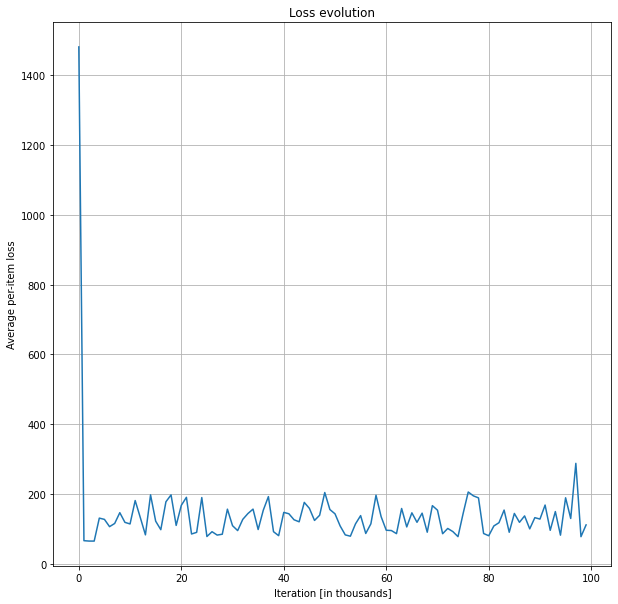

In [12]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

# Part2 Pytorch version

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import time
import matplotlib.pyplot as plt

In [8]:
#if (torch.has_cuda): # do this for automatic switching

doGPU=True
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

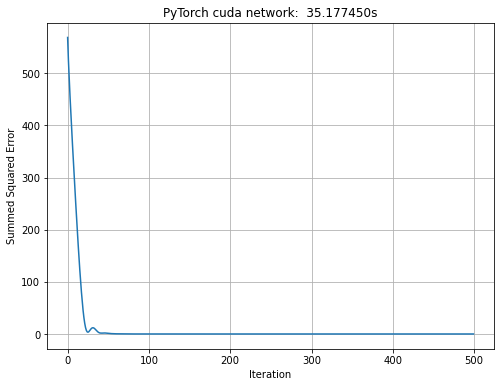

In [19]:
#if (torch.has_cuda): # do this for automatic switching
start=time.time()

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 10000, 10
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# optim = 'adam'

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# After constructing the model we use the .to() method to move it to the
# desired device.

# model = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, H),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H, D_out),
# ).to(device)

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, H+10),
    nn.ReLU(),
    nn.Linear(H+10, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

model.to(device)

# def weights_init(m):
#     if isinstance(m, torch.nn.Linear):
#         size = m.weight.size() # returns a tuple
#         fan_out = size[0] # number of rows
#         fan_in = size[1] # number of columns
#         m.weight.data = torch.randn(fan_out, fan_in, device=device)

# model.apply(weights_init)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function. Setting
# reduction='sum' means that we are computing the *sum* of squared errors rather
# than the mean; this is for consistency with the examples above where we
# manually compute the loss, but in practice it is more common to use mean
# squared error as a loss by setting reduction='elementwise_mean'.

# loss_fn = torch.nn.MSELoss(reduction = "sum")

learning_rate = 1e-5
max_iterations = 500
# l2_errors = np.zeros(max_iterations)
loss_func = nn.MSELoss(reduction="sum")
loss_array = []

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
# learning_rate = 1e-4
# if optim == "adam":
#     optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# elif optim == "SGD":
#     optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)


# optimizer = optim.Adam(model.parameters(), lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)


for it in range(max_iterations):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    optimizer.zero_grad()
    y_pred = model(x) 
    
    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the loss.
    loss = loss_func(y_pred, y)
    loss.backward()
    optimizer.step()

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss_array.append(loss.item())


    # Calling the step function on an Optimizer makes an update to its parameters

total_time = time.time()-start
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(loss_array)
plt.xlabel('Iteration')
plt.ylabel('Summed Squared Error')
plt.title('PyTorch {0:} network: {1: 0.6f}s'.format(device,total_time))
plt.grid()

In [13]:
print(model)

Sequential(
  (0): Linear(in_features=1000, out_features=10000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10000, out_features=10010, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10010, out_features=10000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10000, out_features=10, bias=True)
)


In [14]:
x = torch.randn(512, 1000).requires_grad_(True).to(device)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()))).render("torchviz", format="png")
plt.figure(figsize=(10,20))
img = mpimg.imread('torchviz.png')
plt.imshow(img)
plt.show()

NameError: name 'make_dot' is not defined

In [ ]:
# if above not working ... conda install python-graphviz
